In [2]:
!pip install gdown
!pip install keras_tuner

In [3]:
import gdown  
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

from io import StringIO
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Reshape, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

import keras
import keras_tuner as kt  # Simplified import for keras_tuner
from keras_tuner.tuners import RandomSearch, BayesianOptimization
import seaborn as sns

hp = kt.HyperParameters()


# DATA UPLOAD AND PREPROCESSING

In [4]:
url = 'https://drive.google.com/uc?id=1f8wwVmV4JXc-iT4UH-RlYxTPQ0a1OFuj'
# filename
output = 'public_data.npz'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1f8wwVmV4JXc-iT4UH-RlYxTPQ0a1OFuj
From (redirected): https://drive.google.com/uc?id=1f8wwVmV4JXc-iT4UH-RlYxTPQ0a1OFuj&confirm=t&uuid=610bec97-7e62-4be9-8f7c-1c384ca20add
To: /kaggle/working/public_data.npz
100%|██████████| 575M/575M [00:06<00:00, 85.4MB/s] 


'public_data.npz'

In [5]:
# Separate the images and the labels

dataset = np.load('public_data.npz', allow_pickle=True)
images = dataset["data"]
labels = dataset["labels"]
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)
labels = np.unique(dataset["labels"], return_inverse=True)[1]

In [6]:
unique_elements, counts_elements = np.unique(labels, return_counts=True)

print("zero images: %d\n one images: %d" % (counts_elements[0], counts_elements[1]))

zero images: 3199
 one images: 2001


In [7]:
# Normalize the images to the range [0, 1]
if images.max() > 1:  # Check if normalization is needed
    images = images / 255.0  # Normalize all images

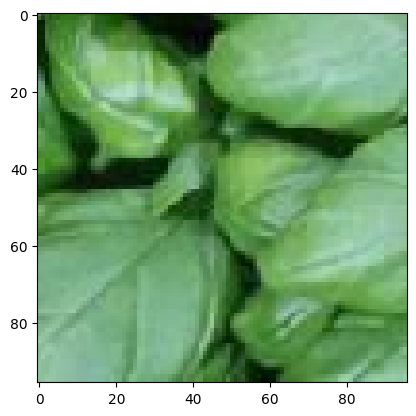

In [14]:
import matplotlib.pyplot as plt

plt.imshow(images[1], interpolation='nearest')
plt.show()

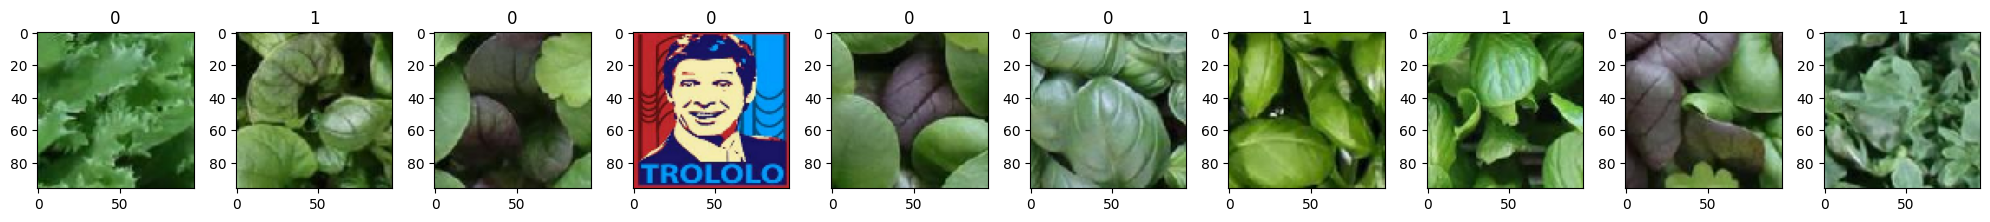

In [11]:
# Display a sample of images from the dataset
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i in range(num_img):
    idx = np.random.randint(len(images))
    ax = axes[i % num_img]
    ax.imshow(images[idx])
    ax.set_title('{}'.format(labels[idx]))

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [12]:
# Cleaning the Dataset
flattened_images = images.reshape(images.shape[0], -1)
db = DBSCAN(eps=0.1, min_samples=10).fit(flattened_images)
labelss = db.labels_
n_clusters_ = len(set(labelss)) - (1 if -1 in labelss else 0)
n_noise_ = list(labelss).count(-1)
unique_elements, counts_elements = np.unique(labelss, return_counts=True)
print("  plants cluster: %d\n   shrek cluster:  %d\n    meme cluster:  %d" % (counts_elements[0], counts_elements[1], counts_elements[2]))

  plants cluster: 5004
   shrek cluster:  98
    meme cluster:  98


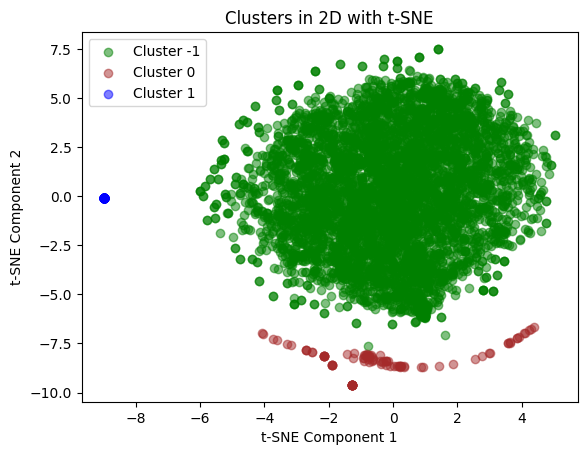

In [80]:
# t-SNE PLOTTING

# Reduce the dimensionality of the images to 2 components for 2D plotting
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(flattened_images)

# Define the colors for each cluster
cluster_colors = { -1: 'green', 0: 'brown', 1: 'blue'}

# Plot each cluster using t-SNE results
for cluster_label in np.unique(labelss):
    # Select the data points that belong to the current cluster
    in_cluster = labelss == cluster_label
    cluster_data = tsne_results[in_cluster]

    # Plot those data points with the cluster's color
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1],
                c=cluster_colors[cluster_label], label=f'Cluster {cluster_label}', alpha=0.5)

# Label the axes and show the plot
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Clusters in 2D with t-SNE')
plt.legend()
plt.show()

In [13]:
# Masking
cluster_good_indices = np.where(labelss == -1)[0]
mask = np.zeros(len(labels), dtype=bool)
mask[cluster_good_indices] = True

# Apply the mask to both labels and images.
labels = labels[mask]
images = images[mask]

In [14]:
# Splitting in train test and validation
trainD, tempD, trainL, tempL = train_test_split(images, labels, test_size=0.20, random_state=42)
valD, testD, valL, testL = train_test_split(tempD, tempL, test_size=0.50, random_state=42)

# Now you have train, validation, and test sets
print("Training Data Shape:", trainD.shape)
print("Validation Data Shape:", valD.shape)
print("Test Data Shape:", testD.shape)

Training Data Shape: (4003, 96, 96, 3)
Validation Data Shape: (500, 96, 96, 3)
Test Data Shape: (501, 96, 96, 3)


# HP TUNING THROUGH KERAS TUNER

In [15]:
def build_model(hp):
    M = keras.Sequential()
    M.add(keras.Input(shape=(96, 96, 3)))
    M.add(keras.layers.GlobalAveragePooling2D())
    for L in range(hp.Int("num_layers", 1, 5)):
        M.add(keras.layers.Dense(units=hp.Int(f"units_{L}", min_value=700, max_value=900, step=50), activation='relu'))
    M.add(keras.layers.Dense(1, activation='sigmoid'))
    M.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return M

In [16]:
tuner = kt.BayesianOptimization(
 hypermodel=build_model, 
 objective="val_accuracy", 
 max_trials=10, 
 executions_per_trial=1, 
 overwrite=True, 
 directory="/tmp", 
 project_name="plant", 
)

tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 700, 'max_value': 900, 'step': 50, 'sampling': 'linear'}


In [17]:
tuner.search(trainD, trainL, batch_size=32, epochs=10, validation_data=(valD, valL))

Trial 10 Complete [00h 00m 11s]
val_accuracy: 0.6899999976158142

Best val_accuracy So Far: 0.6940000057220459
Total elapsed time: 00h 01m 32s


In [18]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [19]:
print("Best Hyperparameters:")
for hp_name, hp_value in best_hps.values.items():
    print(f"{hp_name}: {hp_value}")

Best Hyperparameters:
num_layers: 4
units_0: 750
units_1: 850
units_2: 900
units_3: 700


# MODEL

In [20]:
M = build_model(best_hps)

In [15]:
M.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d_1      │ (None, 3)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 700)            │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 700)            │       490,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 700)            │       490,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           701 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 984,901 (3.76 MB)

 Trainable params: 984,901 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
H = M.fit(trainD, trainL, 
                validation_data=(valD, valL), 
                epochs=150,  
                batch_size=32,
                callbacks=[
                      tf.keras.callbacks.EarlyStopping(
                          monitor='val_accuracy',
                          mode='max',
                          patience=20,
                          restore_best_weights=True
                      )
                  ])

Epoch 1/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6244 - loss: 0.6638 - val_accuracy: 0.6260 - val_loss: 0.6555
Epoch 2/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6353 - loss: 0.6564 - val_accuracy: 0.6300 - val_loss: 0.6555
Epoch 3/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5891 - loss: 0.6726 - val_accuracy: 0.6260 - val_loss: 0.6530
Epoch 4/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6115 - loss: 0.6664 - val_accuracy: 0.6260 - val_loss: 0.6675
Epoch 5/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6390 - loss: 0.6520 - val_accuracy: 0.6280 - val_loss: 0.6561
Epoch 6/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6277 - loss: 0.6575 - val_accuracy: 0.6900 - val_loss: 0.6264
Epoch 7/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6295 - loss: 0.6644 - val_accuracy: 0.6260 - val_loss: 0.6582
Epoch 8/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6258 - loss: 0.6603 - val_acc

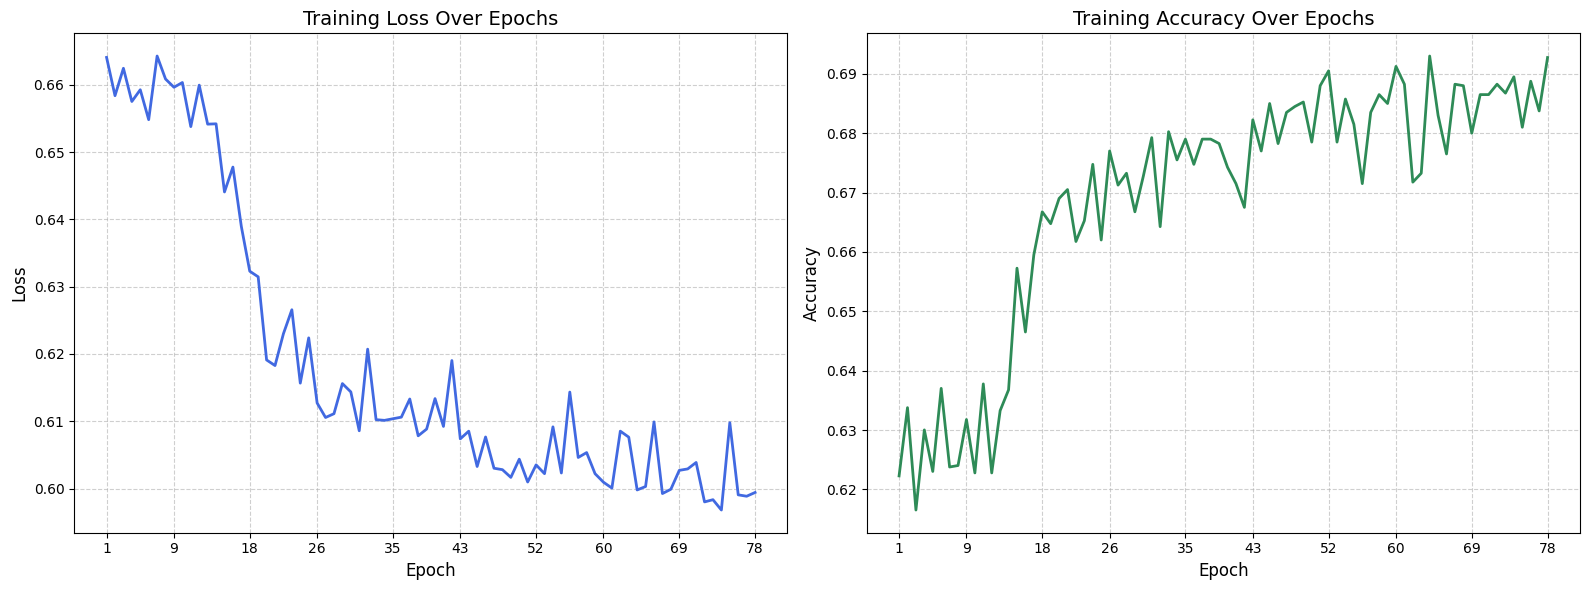

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
xx = np.arange(1, len(H.history['loss']) + 1)
# Plot 1: Loss
ax = axes[0]
ax.plot(xx, H.history['loss'], color='royalblue', linewidth=2)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss Over Epochs', fontsize=14)
ax.set_xticks(np.linspace(1, len(H.history['loss']), 10, dtype=int))
# Plot 2: Accuracy
ax = axes[1]
ax.plot(xx, H.history['accuracy'], color='seagreen', linewidth=2)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Training Accuracy Over Epochs', fontsize=14)
ax.set_xticks(np.linspace(1, len(H.history['accuracy']), 10, dtype=int))

plt.tight_layout()
plt.show()

In [23]:
 # Evaluate model
trainLoss, trainAccuracy = M.evaluate(trainD, trainL, verbose=False)
valLoss, valAccuracy = M.evaluate(valD, valL, verbose=False)
testLoss, testAccuracy = M.evaluate(testD, testL, verbose=False)
# Print the results
print(f"Training Loss: {trainLoss:.4f}, Training Accuracy: {trainAccuracy:.4f}")
print(f"Validation Loss: {valLoss:.4f}, Validation Accuracy: {valAccuracy:.4f}")
print(f"Test Loss: {testLoss:.4f}, Test Accuracy: {testAccuracy:.4f}")

Training Loss: 0.5957, Training Accuracy: 0.6905
Validation Loss: 0.5881, Validation Accuracy: 0.7200
Test Loss: 0.5943, Test Accuracy: 0.7086


In [24]:
predictions = M.predict(testD)
predicted_classes = (predictions > 0.5).astype(int).flatten()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


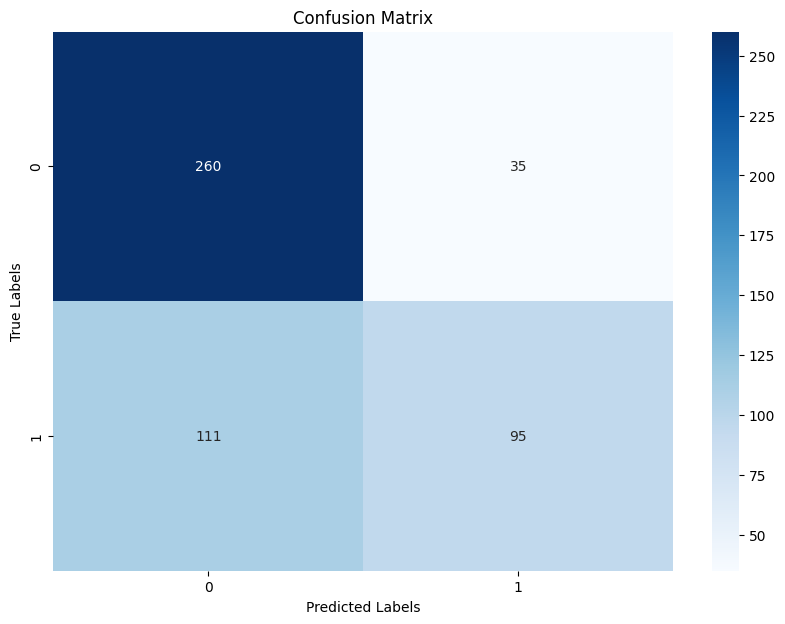

In [25]:
# Compute the confusion matrix
cm = confusion_matrix(testL, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(testL), 
            yticklabels=np.unique(testL))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()